In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
np.random.seed(42)

In [31]:
def load_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
    columns = [
        'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
        'savings_account', 'employment', 'installment_rate', 'personal_status', 'other_debtors',
        'residence_since', 'property', 'age', 'other_installment', 'housing',
        'existing_credits', 'job', 'num_dependents', 'telephone', 'foreign_worker', 'credit_risk'
    ]
    df = pd.read_csv(url, sep=' ', header=None, names=columns)
    return df

In [32]:
def explore_data(df):
    print("Dataset Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    print("\n=== Class Distribution ===")
    class_counts = df['credit_risk'].value_counts()
    print(f"Class 1 (Good Credit Risk): {class_counts[1]}")
    print(f"Class 2 (Bad Credit Risk): {class_counts[2]}")
    class_imbalance_ratio = class_counts[2] / class_counts[1]
    plt.figure(figsize=(8, 6))
    sns.countplot(x='credit_risk', data=df)
    plt.title('Distribution of Credit Risk')
    plt.show()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
    return class_imbalance_ratio

In [33]:
def preprocess_data(df):
    df_processed = df.copy()
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in categorical_cols:
        df_processed[col] = le.fit_transform(df_processed[col])
    df_processed['credit_amount_to_duration'] = df_processed['credit_amount'] / df_processed['duration']
    df_processed['age_group'] = pd.cut(df_processed['age'], bins=[0, 30, 50, 100], labels=['young', 'middle', 'senior'])
    df_processed['age_group'] = le.fit_transform(df_processed['age_group'])
    X = df_processed.drop('credit_risk', axis=1)
    y = df_processed['credit_risk']
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y, df_processed.columns.drop('credit_risk')

In [34]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    return best_model, metrics, X_test, y_test, y_pred

In [35]:
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    top_features = [(feature_names[i], importance[i]) for i in indices[:3]]
    return top_features

=== Data Exploration ===
Dataset Shape: (1000, 21)

First few rows:
  checking_account  duration credit_history purpose  credit_amount  \
0              A11         6            A34     A43           1169   
1              A12        48            A32     A43           5951   
2              A14        12            A34     A46           2096   
3              A11        42            A32     A42           7882   
4              A11        24            A33     A40           4870   

  savings_account employment  installment_rate personal_status other_debtors  \
0             A65        A75                 4             A93          A101   
1             A61        A73                 2             A92          A101   
2             A61        A74                 2             A93          A101   
3             A61        A74                 2             A93          A103   
4             A61        A73                 3             A93          A101   

   ...  property age  other_in

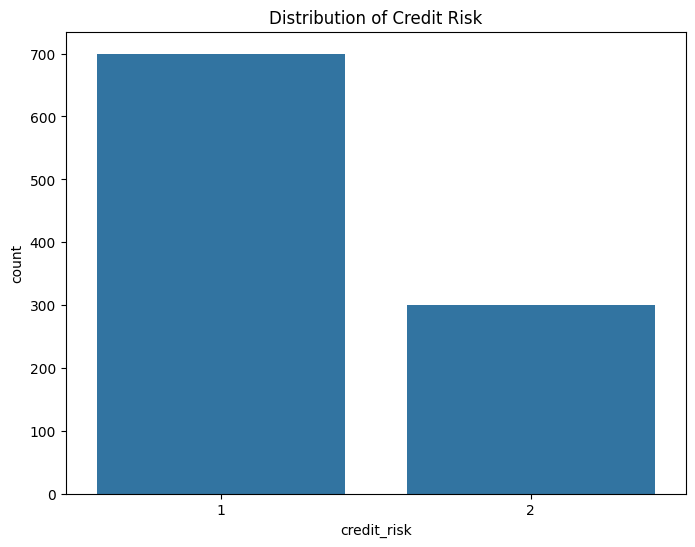

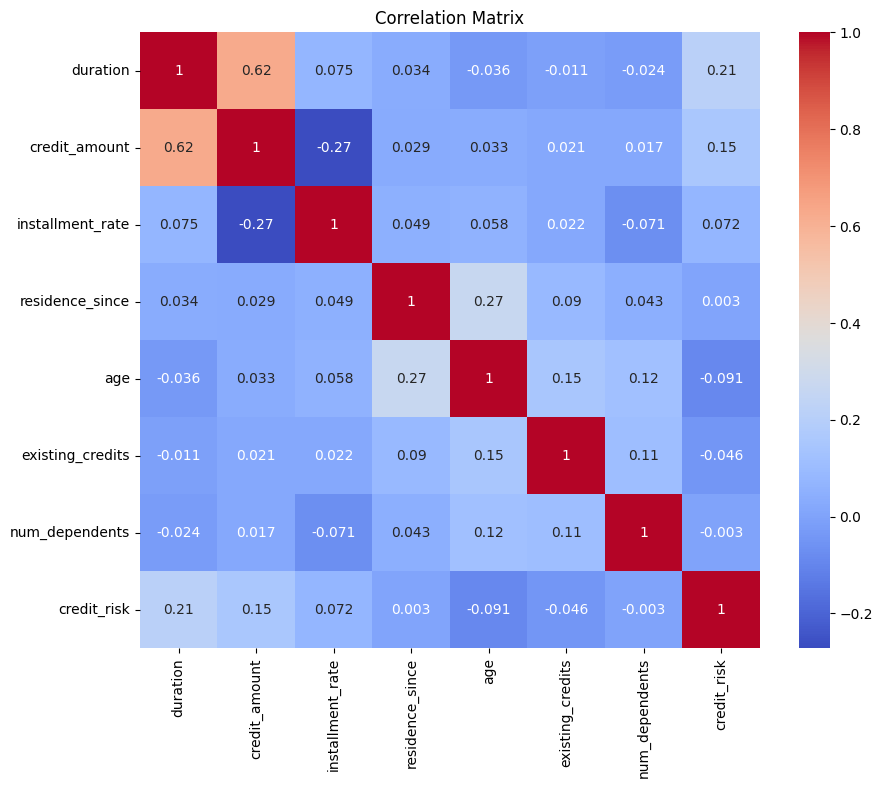


=== Model Training ===

=== Model Performance ===
Accuracy: 0.8050
Precision: 0.8187
Recall: 0.9291
F1-Score: 0.8704

=== Classification Report ===
              precision    recall  f1-score   support

           1       0.82      0.93      0.87       141
           2       0.75      0.51      0.61        59

    accuracy                           0.81       200
   macro avg       0.78      0.72      0.74       200
weighted avg       0.80      0.81      0.79       200


=== Feature Importance ===


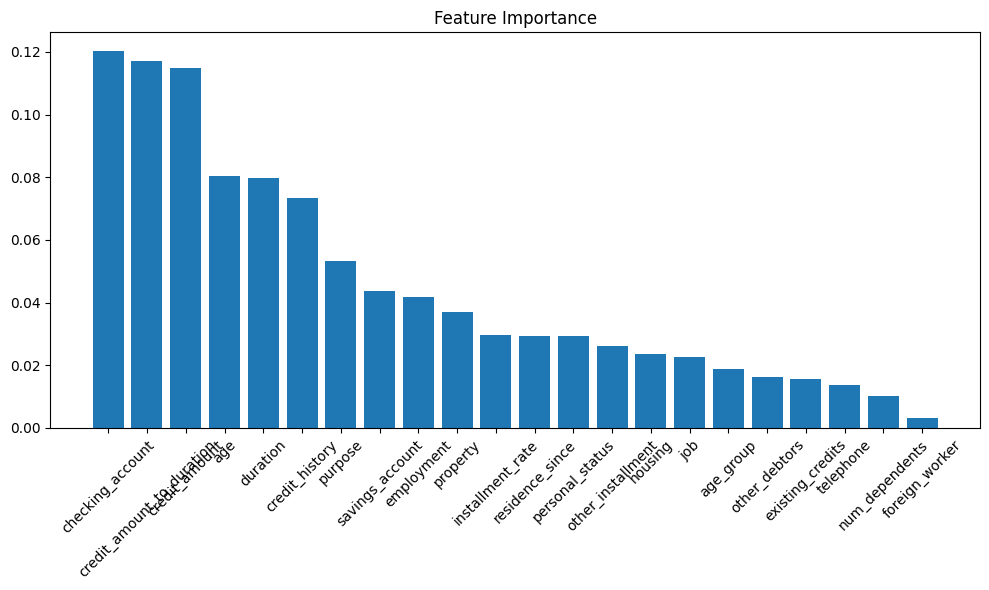


=== Recommendations ===
1. Prioritize evaluation of checking_account, credit_amount_to_duration, credit_amount as they are the most influential features for predicting credit risk.
2. Continue monitoring class distribution to ensure balanced representation of good and bad credit risks.
3. Improve recall for bad credit risk detection by exploring advanced ensemble methods (e.g., XGBoost) or adjusting decision thresholds to minimize false negatives.
4. Enhance model accuracy by incorporating additional features such as income, recent financial transactions, or credit bureau scores, which are not available in the current dataset.


In [37]:
def main():
    df = load_data()
    print("=== Data Exploration ===")
    class_imbalance_ratio = explore_data(df)
    X, y, feature_names = preprocess_data(df)
    print("\n=== Model Training ===")
    model, metrics, X_test, y_test, y_pred = train_model(X, y)
    print("\n=== Model Performance ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    class_2_recall = recall_score(y_test, y_pred, pos_label=2)
    print("\n=== Feature Importance ===")
    top_features = plot_feature_importance(model, feature_names)
    print("\n=== Recommendations ===")
    recommendations = []
    top_feature_names = [f[0] for f in top_features]
    recommendations.append(
        f"1. Prioritize evaluation of {', '.join(top_feature_names)} as they are the most influential features for predicting credit risk."
    )
    if class_imbalance_ratio > 0.5:
        recommendations.append(
            "2. Address class imbalance (bad credit risk cases are less frequent) by using techniques like SMOTE or class weights to improve model performance on minority class."
        )
    else:
        recommendations.append(
            "2. Continue monitoring class distribution to ensure balanced representation of good and bad credit risks."
        )
    if class_2_recall < 0.7:
        recommendations.append(
            "3. Improve recall for bad credit risk detection by exploring advanced ensemble methods (e.g., XGBoost) or adjusting decision thresholds to minimize false negatives."
        )
    else:
        recommendations.append(
            "3. Maintain high recall for bad credit risk detection by regularly validating the model with new data."
        )
    recommendations.append(
        "4. Enhance model accuracy by incorporating additional features such as income, recent financial transactions, or credit bureau scores, which are not available in the current dataset."
    )
    for rec in recommendations:
        print(rec)

if __name__ == "__main__":
    main()